# Library & Data

In [1]:
#NRCLex
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')
from nrclex import NRCLex

import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
import datasets

import spacy
spacy.load("en_core_web_sm")


/usr/local/lib/python3.9/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
#BERT
import pickle
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from torch.utils.data import DataLoader



In [3]:
dataset = load_dataset('emotion', name = "split")

Found cached dataset emotion (/Users/martenjst/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)
100%|██████████| 3/3 [00:00<00:00, 58.44it/s]


In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# NRClex

In [2]:
nlp = spacy.load('en_core_web_sm')

In [125]:
to_pred = dataset["validation"]
df_test = pd.DataFrame(data=to_pred,columns=to_pred.features)
df_test


,text,label
0,im feeling quite sad and sorry for myself but ...,0
1,i feel like i am still looking at a blank canv...,0
2,i feel like a faithful servant,2
3,i am just feeling cranky and blue,3
4,i can have for a treat or if i am feeling festive,1
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


In [ ]:
def detect_emotion(text):
    temp = [word.lemma_ for word in nlp(text)]
    text = " ".join(temp)
    text_object = NRCLex(text=text)
    top_em = text_object.top_emotions
    filtered_list = list(filter(lambda x: x[0] != "positive" and x[0] != "negative" and x[0] != "anticipation" and x[0] != "disgust",  top_em))
    try:
        return filtered_list[0][0]
    except IndexError:
        return "undefined"

preds_nrclex = df_test["text"].apply(detect_emotion)

In [236]:
emotion_dict = {'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5, 'undefined':-1}

In [ ]:
# use the map() method to apply the mapping to the labels
numeric_labels = preds_nrclex.map(emotion_dict)

print(numeric_labels)


In [238]:
print('Precision: %.3f' % metrics.precision_score(val_dataset["label"], numeric_labels, average="macro"))
print('Recall: %.3f' % metrics.recall_score(val_dataset["label"], numeric_labels,average="macro"))
print('Accuracy: %.3f' % metrics.accuracy_score(val_dataset["label"], numeric_labels))

Precision: 0.145
Recall: 0.124
Accuracy: 0.131


/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

In [105]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")


def tokenize_function(data):
    return tokenizer(data["text"], truncation=True, padding='max_length')

def tokenize_function_pred(data):
    return tokenizer(data["lemmatized_text"], truncation=True,padding='max_length')


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /Users/martenjst/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "tokenizer_class": "BertweetTokenizer",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache

In [106]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /Users/martenjst/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-88aae8a92e2be4cb.arrow
Loading cached processed dataset at /Users/martenjst/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-7390907aad2342f8.arrow


In [8]:
from datasets import Dataset
import datasets


In [119]:
dataset_pred = Dataset.from_pandas(df[["lemmatized_text","conversation_id"]])

In [120]:
tokenized_dataset_pred = dataset_pred.map(tokenize_function_pred, batched=True)

In [17]:
test = tokenized_datasets["train"]

In [107]:

small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)


Loading cached shuffled indices for dataset at /Users/martenjst/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-0aff67d26e8a3806.arrow


In [116]:
val_dataset = tokenized_datasets["validation"].shuffle(seed=42)

Loading cached shuffled indices for dataset at /Users/martenjst/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd/cache-bf95bcc4df194dff.arrow


In [108]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/bertweet-base", num_labels=6)

loading configuration file config.json from cache at /Users/martenjst/.cache/huggingface/hub/models--vinai--bertweet-base/snapshots/118ab1d567653bec16bbb081eafb6f8942f72108/config.json
Model config RobertaConfig {
  "_name_or_path": "vinai/bertweet-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 130,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
 

In [109]:

import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [110]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [111]:

from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [112]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)
 

In [65]:
tokenized_dataset_pred = tokenized_dataset_pred.rename_column("lemmatized_text", "text")
tokenized_dataset_pred

Dataset({
    features: ['text', 'conversation_id', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 117824
})

In [113]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 16000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6000
  Number of trainable parameters = 134904582
  8%|▊         | 500/6000 [35:08<5:43:50,  3.75s/it] Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test

{'loss': 0.7815, 'learning_rate': 4.5833333333333334e-05, 'epoch': 0.25}


Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
 17%|█▋        | 1000/6000 [1:07:47<5:25:40,  3.91s/it]Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json


{'loss': 0.3773, 'learning_rate': 4.166666666666667e-05, 'epoch': 0.5}


Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
 25%|██▌       | 1500/6000 [1:40:17<4:39:13,  3.72s/it]Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json


{'loss': 0.3097, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.75}


Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
 33%|███▎      | 2000/6000 [2:12:13<4:13:34,  3.80s/it]Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json


{'loss': 0.2369, 'learning_rate': 3.3333333333333335e-05, 'epoch': 1.0}


Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8

 33%|███▎      | 2000/6000 [2:16:38<4:13:34,  3.80s/it]

{'eval_loss': 0.19242124259471893, 'eval_accuracy': 0.9345, 'eval_runtime': 261.8568, 'eval_samples_per_second': 7.638, 'eval_steps_per_second': 0.955, 'epoch': 1.0}


 42%|████▏     | 2500/6000 [2:48:49<3:40:15,  3.78s/it] Saving model checkpoint to test_trainer/checkpoint-2500
Configuration saved in test_trainer/checkpoint-2500/config.json


{'loss': 0.1905, 'learning_rate': 2.916666666666667e-05, 'epoch': 1.25}


Model weights saved in test_trainer/checkpoint-2500/pytorch_model.bin
 50%|█████     | 3000/6000 [3:20:26<3:06:58,  3.74s/it]Saving model checkpoint to test_trainer/checkpoint-3000
Configuration saved in test_trainer/checkpoint-3000/config.json


{'loss': 0.1573, 'learning_rate': 2.5e-05, 'epoch': 1.5}


Model weights saved in test_trainer/checkpoint-3000/pytorch_model.bin
 58%|█████▊    | 3500/6000 [3:52:24<2:36:31,  3.76s/it]Saving model checkpoint to test_trainer/checkpoint-3500
Configuration saved in test_trainer/checkpoint-3500/config.json


{'loss': 0.1701, 'learning_rate': 2.0833333333333336e-05, 'epoch': 1.75}


Model weights saved in test_trainer/checkpoint-3500/pytorch_model.bin
 67%|██████▋   | 4000/6000 [4:24:24<2:08:46,  3.86s/it]Saving model checkpoint to test_trainer/checkpoint-4000
Configuration saved in test_trainer/checkpoint-4000/config.json


{'loss': 0.1414, 'learning_rate': 1.6666666666666667e-05, 'epoch': 2.0}


Model weights saved in test_trainer/checkpoint-4000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8

 67%|██████▋   | 4000/6000 [4:28:38<2:08:46,  3.86s/it]

{'eval_loss': 0.20700788497924805, 'eval_accuracy': 0.928, 'eval_runtime': 250.3803, 'eval_samples_per_second': 7.988, 'eval_steps_per_second': 0.998, 'epoch': 2.0}


 75%|███████▌  | 4500/6000 [5:01:35<1:34:29,  3.78s/it] Saving model checkpoint to test_trainer/checkpoint-4500
Configuration saved in test_trainer/checkpoint-4500/config.json


{'loss': 0.1164, 'learning_rate': 1.25e-05, 'epoch': 2.25}


Model weights saved in test_trainer/checkpoint-4500/pytorch_model.bin
 83%|████████▎ | 5000/6000 [5:34:26<1:07:33,  4.05s/it]Saving model checkpoint to test_trainer/checkpoint-5000
Configuration saved in test_trainer/checkpoint-5000/config.json


{'loss': 0.101, 'learning_rate': 8.333333333333334e-06, 'epoch': 2.5}


Model weights saved in test_trainer/checkpoint-5000/pytorch_model.bin
 92%|█████████▏| 5500/6000 [6:03:40<26:04,  3.13s/it]  Saving model checkpoint to test_trainer/checkpoint-5500
Configuration saved in test_trainer/checkpoint-5500/config.json


{'loss': 0.1051, 'learning_rate': 4.166666666666667e-06, 'epoch': 2.75}


Model weights saved in test_trainer/checkpoint-5500/pytorch_model.bin
100%|██████████| 6000/6000 [6:29:43<00:00,  3.22s/it]Saving model checkpoint to test_trainer/checkpoint-6000
Configuration saved in test_trainer/checkpoint-6000/config.json


{'loss': 0.1012, 'learning_rate': 0.0, 'epoch': 3.0}


Model weights saved in test_trainer/checkpoint-6000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8
                                                     
100%|██████████| 6000/6000 [6:33:00<00:00,  3.22s/it]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 6000/6000 [6:33:00<00:00,  3.93s/it]

{'eval_loss': 0.1678793579339981, 'eval_accuracy': 0.9355, 'eval_runtime': 192.953, 'eval_samples_per_second': 10.365, 'eval_steps_per_second': 1.296, 'epoch': 3.0}
{'train_runtime': 23580.3474, 'train_samples_per_second': 2.036, 'train_steps_per_second': 0.254, 'train_loss': 0.2323730068206787, 'epoch': 3.0}


TrainOutput(global_step=6000, training_loss=0.2323730068206787, metrics={'train_runtime': 23580.3474, 'train_samples_per_second': 2.036, 'train_steps_per_second': 0.254, 'train_loss': 0.2323730068206787, 'epoch': 3.0})

In [53]:
trainer.evaluate

<bound method Trainer.evaluate of <transformers.trainer.Trainer object at 0x16496cf70>>

In [133]:
preds = trainer.predict(tokenized_dataset_pred)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: lemmatized_text, conversation_id. If lemmatized_text, conversation_id are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 284764
  Batch size = 8
100%|██████████| 35596/35596 [8:50:43<00:00,  1.12it/s]   


In [117]:
pred_val = trainer.predict(val_dataset)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8
100%|██████████| 250/250 [03:13<00:00,  1.29it/s]


In [239]:
logits = preds[:2]
logits = logits[0]
print(logits)

[[-0.5155098  -1.7042539  -1.9254895   6.14985     1.4163653  -2.79727   ]
 [ 0.30221874 -1.0592127  -2.0971081   4.8543396   2.0904047  -3.40608   ]
 [ 0.584542    3.7635105  -1.2743526   1.7553437  -1.2835344  -3.8130176 ]
 ...
 [-0.21859783 -0.43645906 -0.7366928   5.4642234  -0.51075584 -3.2422345 ]
 [-0.9017977   4.7295775  -0.15305275  1.3249084  -2.5543044  -3.1651134 ]
 [-1.6003146   7.539909   -0.718583   -2.119065   -2.4330513  -1.7366103 ]]


In [240]:
# Apply softmax along rows to get probability distributions
probs_array = np.apply_along_axis(lambda x: np.exp(x) / np.sum(np.exp(x)), 1, logits)
probs_array

array([[1.26055884e-03, 3.83970735e-04, 3.07763199e-04, 9.89218116e-01,
        8.70093238e-03, 1.28708503e-04],
       [9.78631247e-03, 2.50816974e-03, 8.88392096e-04, 9.28068638e-01,
        5.85084260e-02, 2.39952569e-04],
       [3.50028388e-02, 8.40836763e-01, 5.45501104e-03, 1.12869337e-01,
        5.40515315e-03, 4.30791784e-04],
       ...,
       [3.36731807e-03, 2.70812213e-03, 2.00575730e-03, 9.89240885e-01,
        2.51420983e-03, 1.63732708e-04],
       [3.42788803e-03, 9.56537187e-01, 7.24773714e-03, 3.17740701e-02,
        6.56677468e-04, 3.56517703e-04],
       [1.07202206e-04, 9.99429941e-01, 2.58901709e-04, 6.38136044e-05,
        4.66176934e-05, 9.35429998e-05]], dtype=float32)

In [152]:
# Find index of maximum probability for each row
max_indices = np.argmax(probs_array, axis=1)

# Find the highest probability for each row
max_probs = np.max(probs_array, axis=1)

In [215]:
print('Precision: %.3f' % metrics.precision_score(val_dataset["label"], max_indices, average="macro"))
print('Recall: %.3f' % metrics.recall_score(val_dataset["label"], max_indices,average="macro"))
print('Accuracy: %.3f' % metrics.accuracy_score(val_dataset["label"], max_indices))

Precision: 0.920
Recall: 0.918
Accuracy: 0.941


In [ ]:
from sklearn import metrics
cm = metrics.confusion_matrix(val_dataset["label"], max_indices)

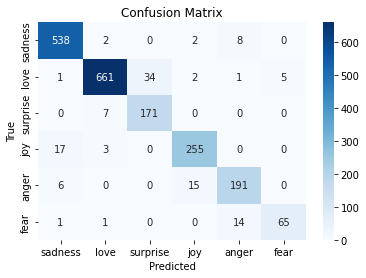

In [157]:
# Define class names
class_names = {'sadness','joy','love','anger','fear', 'surprise'}

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

# Add axis labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show plot
plt.show()